# YT Comments analysis

In [1]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from datetime import datetime, timedelta, time
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from api import API_KEY

channel_id = "UCWeg2Pkate69NFdBeuRFTAw" #Squeezie channel
etoiles = 'UCABf02qOye7XYapcK1M45LQ'
youtube = build('youtube', 'v3', developerKey=API_KEY)
exemple_video = "qCKyRhkhqoQ"
otp_recap = 'F7A8OCdmZ90'

### Class request
Class to handle youtube request since youtube api doesn't provide a request object

In [2]:
class Request:
    """ Class Request handling youtube request as an object """
    def __init__(self, requestType,part=None, id=None, chart=None, regionCode=None, maxResults=None, pageToken=None, videoId=None):
        self.requestType = requestType
        self.part = part
        self.id = id
        self.chart = chart
        self.regionCode = regionCode
        self.maxResults = maxResults
        self.pageToken = pageToken
        self.videoId = videoId
        
    def execute(self):
        param = vars(self) # Fetch class attributes
        param = {x:y for x,y in list(param.items())[1:] if y} # Delete requestType ([1:]) and None attributes
        
        request = self.requestType.list(**param)
        return request.execute()

### Decorator
Decorator to retry when youtube request fails (mostly due to timeout erros)

In [3]:
def retry_on_exception(max_attempts=5):
    def decorator(func):
        def wrapper(*args, **kwargs):
            attempts = 0
            while attempts < max_attempts:
                try:
                    result = func(*args, **kwargs)
                except Exception as e:
                    attempts += 1
                    if attempts == max_attempts:
                        return pd.DataFrame()
                        raise  # Relancer l'exception si le nombre maximal de tentatives est atteint
                    else:
                        print(f"{attempts}: Une exception s'est produite : {e}")
                else:
                    return result  # Retourner le résultat si aucune exception n'est levée
                # time.sleep(0.5)
        return wrapper
    return decorator

### Datetime convertions
Functions to convert iso formated date found in youtube api responses in datetime objects.

In [4]:
def iso_toDatetime(iso_date:str):
    """Converts an ISO 8601 formatted date to a datetime object."""
    return datetime.strptime(iso_date[:-1], '%Y-%m-%dT%H:%M:%S')

def datetime_toISO(dt_obj:datetime):
    """Converts a datetime object to an ISO 8601 formatted date."""
    return dt_obj.isoformat()[:-7]  # remove microseconds

def iso_toDelta(iso_duration:str):
    """Converts an ISO 8601 formatted duration to a timedelta object."""
    match = re.match(r'PT(\d+D)*(\d+H)*(\d+M)*(\d+S)', iso_duration)
    days, hours, minutes, seconds = [int(x[:-1]) if x else 0 for x in match.groups()]
    return timedelta(days=days,hours=hours, minutes=minutes, seconds=seconds)

def delta_toISO(delta_obj:timedelta):
    """Converts a timedelta object to an ISO 8601 formatted duration."""
    hours = delta_obj.seconds // 3600
    minutes = (delta_obj.seconds % 3600) // 60
    seconds = delta_obj.seconds % 60
    
    daysStr = f"{delta_obj.days}D" if delta_obj.days != 0 else ""
    hoursStr = f"{hours}H" if hours != 0 else ""
    minutesStr = f"{minutes}M" if minutes != 0 else ""
    secondsStr = f"{seconds}S" if seconds != 0 else ""
    return f"PT{daysStr}{hoursStr}{minutesStr}{secondsStr}"

# print(iso_toDelta('PT4D3H20M9S'))
# print(delta_toISO(iso_toDelta('PT20M9S')))

### Fectching functions
Functions to fetch channels, comments ant top vids infos.

In [5]:
def format_channel_data(channel_data: dict) -> pd.DataFrame:
    """ Structure raw channel data """
    data = {
        "channel_name": [channel_data.get('snippet', {}).get('title')],
        "channel_id": [channel_data.get('id')],
        "country": [channel_data.get('snippet', {}).get('country',"")],
        **{k:[int(v)] for k,v in channel_data.get('statistics', {}).items() if k != "hiddenSubscriberCount"},
        "topics": [[wikilink.split('/')[-1] for wikilink in channel_data.get('topicDetails', {}).get('topicCategories', [])]],
    }
    return pd.DataFrame.from_dict(data)

In [6]:
def get_channel_data(youtube, channel_id:str) -> dict[str|dict]:
    """ Request (by id) for most important channel stats """
    request = Request(
        requestType=youtube.channels(),
        part="snippet,contentDetails,statistics,topicDetails",
        id=channel_id
    )
    response = request.execute()
    rawData = response.get('items', [])[0]
    return format_channel_data(rawData)
    

get_channel_data(youtube, etoiles)

,channel_name,channel_id,country,viewCount,subscriberCount,videoCount,topics
0,Etoiles,UCABf02qOye7XYapcK1M45LQ,FR,48746854,271000,553,"[Action_game, Role-playing_video_game, Action-..."


In [7]:
def format_video_data(video_data: dict) -> pd.DataFrame:
    """ Structure raw video data """
    data = {
            "title": [video_data.get('snippet', {}).get('title')],
            "id": [video_data.get('id')],
            "publishedAt": [video_data.get('snippet', {}).get('publishedAt')],
            "duration" : [video_data.get('contentDetails').get('duration')],
            "ViewCount" : [int(video_data.get('statistics', {}).get('viewCount', 0))],
            "likeCount" : [int(video_data.get('statistics', {}).get('likeCount', 0))],
            "commentCount" : [int(video_data.get('statistics', {}).get('commentCount', 0))],  
            "tags" : [video_data.get('snippet', {}).get('tags')]
    }
    
    return pd.DataFrame.from_dict(data)

In [8]:
def get_video_data(youtube, video_Id:str) -> dict[str|dict]:
    """ Request (by id) for most important video stats """
    request = Request(
        requestType=youtube.videos(),
        part="snippet,contentDetails,statistics,topicDetails",
        id=video_Id,
    )
    response = request.execute()
    
    rawData = response.get('items', [])[0]
    return format_video_data(rawData)

get_video_data(youtube, exemple_video)

,title,id,publishedAt,duration,ViewCount,likeCount,commentCount,tags
0,"LE JEU DE LA FÈVE (Avec Joyca, Zafeel et Hctuan)",qCKyRhkhqoQ,2024-02-10T12:02:00Z,PT35M30S,2732048,186044,2031,"[Mastu, Mastus, Humour, Matsu, loat, mastu loa..."


In [9]:
def get_Most_Popular_Video(youtube, region:str) -> pd.DataFrame:
    """ Request for most populars videos stats """
    request = Request(
        requestType=youtube.videos(),
        part="snippet,contentDetails,statistics,topicDetails",
        chart="mostPopular",
        regionCode=region,
        maxResults=100,
        pageToken=''
    )
    response = request.execute()
    
    pages = [response]
    while response.get('nextPageToken'):
        request.pageToken = response.get('nextPageToken')
        response = request.execute()
        pages.append(response)
    
    top_videos = pd.concat([format_video_data(videos) for page in pages for videos in page.get('items')]).reset_index(drop=True)
    top_videos['topID'] = top_videos.index + 1
    top_videos['region'] = region
    return top_videos

get_Most_Popular_Video(youtube, 'FR')
# df.sort_values(by=['fetchedDate'], ascending=False, inplace=True, kind='quicksort', ignore_index=True)
# df

,title,id,publishedAt,duration,ViewCount,likeCount,commentCount,tags,topID,region
0,Le résumé de Real Sociedad / PARIS SG - Ligue ...,L8sSEvjKU2k,2024-03-05T21:59:15Z,PT9M42S,1232648,17090,662,"[football, ligue 1]",1,FR
1,ZEN #10 avec Domingo - Saison 3,w6IbOWcK89I,2024-03-05T18:20:18Z,PT1H44M50S,198941,8440,317,"[humour, emission, lateshow, live, stream, str...",2,FR
2,🔴🔵 REAL SOCIEDAD - PSG LIVE / 🔥ALLEZ PARIS! / ...,LVm0dIXb9dA,2024-03-05T22:28:25Z,PT3H49M21S,438731,18195,60,"[foot, football, streaming, direct, match, sow...",3,FR
3,On visite un Bunker de Milliardaire,WqnKjcKRQ4E,2024-03-05T16:02:20Z,PT26M4S,248525,14870,768,"[bunker, kansas, survivaliste, fin du monde, a...",4,FR
4,Il a fait un Film sur ma vie ! (Je réagis et j...,NXPsH65WZIM,2024-03-05T17:30:02Z,PT22M38S,406662,27442,472,"[inoxtag, inox, film sur inox, inox film, fan ...",5,FR
...,...,...,...,...,...,...,...,...,...,...
195,Essai : Peugeot 3008 2024 - C'est Compliqué !,ZyAoRhwqrqM,2024-02-28T17:32:31Z,PT19M31S,156746,2524,615,"[peugeot 3008, 3008, 3008 2024, nouveau 3008, ...",196,FR
196,France - Qatar : les enjeux d'une visite (Mbap...,sE-_do1tQBA,2024-02-28T19:45:06Z,PT11M53S,136973,4189,405,None,197,FR
197,Niaks - A las seis (Clip officiel),NMwFt8tBOeg,2024-02-27T17:00:10Z,PT3M11S,364590,8371,297,None,198,FR
198,"Dairy News: New Update, St. Patrick's and Easter",r8MlQJsSsA4,2024-02-29T08:00:07Z,PT4M55S,1006183,22039,1093,"[Hay Day, HayDay, Supercell, Suprcell, Farming...",199,FR


In [10]:
def format_comment_data(comment:dict) -> pd.DataFrame:
    """ Structure raw comment data """
    data = {
        "id": [comment.get('id')],
        "comment": [comment.get('snippet', {}).get('textOriginal')],
        # "viewerRating": comment.get('snippet', {}).get('viewerRating'),
        "likeCount": [int(comment.get('snippet', {}).get('likeCount'))],
        "publishedAt": [comment.get('snippet', {}).get('publishedAt')],
        "updatedAt": [comment.get('snippet', {}).get('updatedAt')]
        }
    
    return data

def format_threadedComment_data(comment:dict) -> pd.DataFrame:
    """ Structure raw threaded comment data """
    data = {
        **format_comment_data(comment.get('snippet', {}).get('topLevelComment')),
        "totalReplyCount": [int(comment.get('snippet', {}).get('totalReplyCount'))],
        # "replies": [format_comment_data(com) for com in comment.get('replies', {}).get('comments', [])]
        }
    
    return data

In [11]:
def format_commentPage(page:list[dict]) -> pd.DataFrame:
    data = {}
    for comment in page:
        topLevelComment = comment.get('snippet', {}).get('topLevelComment')
        data.setdefault("id", []).append(topLevelComment.get('id')) 
        data.setdefault("comment", []).append(topLevelComment.get('snippet', {}).get('textOriginal'))
        data.setdefault("likeCount", []).append(int(topLevelComment.get('snippet', {}).get('likeCount')))
        data.setdefault("publishedAt", []).append(topLevelComment.get('snippet', {}).get('publishedAt'))
        data.setdefault("updatedAt", []).append(topLevelComment.get('snippet', {}).get('updatedAt'))
        data.setdefault("totalReplyCount", []).append(int(comment.get('snippet', {}).get('totalReplyCount')))
    return pd.DataFrame(data)

In [12]:
def get_comment(youtube,comment_id:str) -> dict[str|dict]:
    """ Request (by id) for most important comment stats """
    request = Request(
        requestType=youtube.comments(),
        part="snippet,id",
        id=comment_id,
    )
    response = request.execute()
    rawData = response.get('items')[0]
    return pd.DataFrame(format_comment_data(rawData))

get_comment(youtube, 'UgwUQR2JJFJSkihWLhx4AaABAg')

,id,comment,likeCount,publishedAt,updatedAt
0,UgwUQR2JJFJSkihWLhx4AaABAg,Avez vous déjà rêvé de la vie de pirate dans v...,28,2024-02-08T21:54:35Z,2024-02-27T15:44:14Z


In [13]:
@retry_on_exception(max_attempts=3)
def get_video_commentThreads(youtube, videoID:str, maxComments:int) -> dict[str|list]:
    """ Request (by id) for all comments of a videos """
    request = Request(
        requestType=youtube.commentThreads(),
        part="snippet,id,replies",
        videoId=videoID,
        maxResults=100
    )
    response = request.execute()
    
    maxComments -= response.get('pageInfo', {}).get('totalResults')
    comments = format_commentPage(response.get('items',{}))
    while response.get('nextPageToken'):
        request.pageToken = response.get('nextPageToken')
        response = request.execute()
        comments = pd.concat([comments, format_commentPage(response.get('items',{}))], ignore_index=True)
        if (maxComments:= maxComments - response.get('pageInfo', {}).get('totalResults')) <= 0:
            break
        
    comments['videoID'] = videoID
    comments['fetchedDate'] = datetime.today()
    return comments

get_video_commentThreads(youtube, 'FkXhKu80CWU', 1000)
# get_video_commentThreads(youtube, 'FkXhKu80CWU', 1000)

,id,comment,likeCount,publishedAt,updatedAt,totalReplyCount,videoID,fetchedDate
0,UgyQ7j9yI5eHRgycDAJ4AaABAg,Gonna be a big year. 😁\nIf you'd like to help ...,72072,2024-02-23T02:25:43Z,2024-02-23T02:26:03Z,750,FkXhKu80CWU,2024-03-06 15:06:51.688732
1,UgyixcWsJBgxxhtMMDZ4AaABAg,💀 1:53 2:24,0,2024-03-06T14:04:39Z,2024-03-06T14:06:29Z,0,FkXhKu80CWU,2024-03-06 15:06:51.688732
2,Ugw9NALr0vlvv5jcSVp4AaABAg,Unlocken,0,2024-03-06T14:02:56Z,2024-03-06T14:02:56Z,0,FkXhKu80CWU,2024-03-06 15:06:51.688732
3,UgzewYMoE3SzYrKEhYd4AaABAg,Epic,0,2024-03-06T14:02:04Z,2024-03-06T14:02:04Z,0,FkXhKu80CWU,2024-03-06 15:06:51.688732
4,UgxDxUqleYXQgsc6KCF4AaABAg,2,0,2024-03-06T13:58:18Z,2024-03-06T13:58:18Z,0,FkXhKu80CWU,2024-03-06 15:06:51.688732
...,...,...,...,...,...,...,...,...
995,Ugy9gWVWdnQk-zCrV_R4AaABAg,Siiiiiiiiiiiiiiiii vamos ❤❤❤❤😊❤❤,1,2024-03-05T02:31:01Z,2024-03-05T02:31:01Z,0,FkXhKu80CWU,2024-03-06 15:06:51.688732
996,UgwT5_tnvK3LqwrgVyd4AaABAg,Pq hay puros comentarios de gringos?,1,2024-03-05T02:29:40Z,2024-03-05T02:29:40Z,0,FkXhKu80CWU,2024-03-06 15:06:51.688732
997,Ugxqi1oXapDNnenMvAl4AaABAg,I know glitch probably will not see this but\n...,1,2024-03-05T02:25:01Z,2024-03-05T02:25:01Z,0,FkXhKu80CWU,2024-03-06 15:06:51.688732
998,Ugz5HwQKpQNynFmErG94AaABAg,What,0,2024-03-05T02:22:18Z,2024-03-05T02:22:18Z,0,FkXhKu80CWU,2024-03-06 15:06:51.688732


# Fetching Top Videos
The goal is to fetch the top 200 videos everyday and to get their comments a week after publishing.

In [15]:
def push_top_vids(topvidsFile:str, regions:list[str], minElapsedTime:int)-> None:
    """ Fetch top 200 vids per region (per <minElapsedTime>) and push in json <topvidsFile> """
    today = datetime.today()
    try:
        df = pd.read_csv(topvidsFile)
    except pd.errors.EmptyDataError:
        df = pd.DataFrame()
    
    if 'fetchedDate' in df:
        df['fetchedDate'] = pd.to_datetime(df['fetchedDate'], format='ISO8601')
        lastUpdate = df.sort_values(by=['fetchedDate'], ascending=False, ignore_index=True).loc[0]['fetchedDate']
        delta = today - lastUpdate
        if delta.total_seconds() // 3600 < minElapsedTime:
            raise Exception(f'The fetch request has be done too soon. Next request available in {24-(delta.total_seconds() // 3600)}h. Last update done : {lastUpdate}')

    # Fetching
    for reg in regions:
        top200 = get_Most_Popular_Video(youtube, reg)
        top200['fetchedDate'] = today
        top200['fetchedComments'] = False
        df = pd.concat([df, top200])
        
    df.to_csv('db/dailyTop200.csv', index=False) 

In [16]:
REGION = ['FR', 'US']
topvids = 'db/dailyTop200.csv'
commentsQueue="db/comments.csv"
minElapsedTime = 24 # Hours
minElapsedCommentsTime = 17 # days

push_top_vids(topvids, REGION, minElapsedTime)

Exception: The fetch request has be done too soon. Next request available in 7.0h. Last update done : 2024-03-05 21:38:17.516520

In [35]:
def fetch_topVids_comments(topvidsFile:str, commentsFile:str,minElapsedCommentsTime:int, maxComments:int = 1000) -> None:
    today = datetime.today()
    try:
        df = pd.read_csv(topvidsFile)
        comments = pd.read_csv(commentsFile)
    except pd.errors.EmptyDataError:
        df = pd.DataFrame()
        comments = pd.DataFrame()
    df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='ISO8601')
    
    print(df.dtypes)
    print(df.shape)
    
    uniqueID = df.drop_duplicates(['id'])
    uniqueID = uniqueID[uniqueID['fetchedComments'] == False]
    id_list = list(uniqueID['id'])
    
    for id in id_list:
        if (pd.to_datetime(today) - uniqueID.loc[uniqueID['id'] == id, 'publishedAt'].values[0]).days >= minElapsedCommentsTime:
            print(id)
            comments = pd.concat([comments, get_video_commentThreads(youtube, id, maxComments)])
            df.loc[df['id'] == id, 'fetchedComments'] = True
            
    df.to_csv(topvidsFile, index=False)
    comments.to_csv(commentsFile, index=False)    
    # return comments


In [36]:
fetch_topVids_comments(topvids, commentsQueue, minElapsedCommentsTime, 1000)

/tmp/ipykernel_324/2745607851.py:5: DtypeWarning: Columns (0,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv(commentsFile)


title                           object
id                              object
publishedAt        datetime64[ns, UTC]
duration                        object
ViewCount                        int64
likeCount                      float64
commentCount                   float64
tags                            object
fetchedDate                     object
topID                            int64
region                          object
fetchedComments                   bool
dtype: object
(5200, 12)


## Satistics
Some stats about the comments and top vids.

In [70]:
com = pd.read_csv('db/comments.csv')
df = pd.read_csv('db/dailyTop200.csv')

/tmp/ipykernel_324/3290452696.py:1: DtypeWarning: Columns (0,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  com = pd.read_csv('db/comments.csv')


In [72]:
# df[df['topID'] == 1].sort_values(by=['ViewCount', 'likeCount'], ascending=False)

vals = df[df['id'] == 'tWYsfOSY9vY'][['title','ViewCount', 'likeCount']].drop_duplicates().values
for title,view,like in vals:
    print(f'One every {round(view/like)} person droped a like on `{title}`')
df
# df[df['id'] == '_9u4sYHcR7A'][['topID', 'region', 'fetchedDate']]

One every 18 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 20 person droped a like on `I Survived 7 Days In An Abandoned City`
One every 21 person droped a like on `I Survived 7 Days In An Abandoned City`


,title,id,publishedAt,duration,ViewCount,likeCount,commentCount,tags,fetchedDate,topID,region,fetchedComments
0,Les vacances des Croûtons qui démarrent pas co...,c1FLpmpo50c,2024-02-20 19:00:28+00:00,PT29M28S,1209392,122489.0,3763.0,"['Vacances des croûtons', 'croûton', 'team cro...",2024-02-21 18:55:50.000000,1,FR,True
1,ZEN #9 avec Hugo Décrypte - Saison 3,ib09Xa-XCPA,2024-02-20 18:00:19+00:00,PT2H2M11S,275222,13560.0,419.0,"['humour', 'emission', 'lateshow', 'live', 'st...",2024-02-21 18:55:50.000000,2,FR,True
2,Elle défigure son amie par vengeance ?! - SIP ...,wT4OslqusSo,2024-02-19 16:02:00+00:00,PT1H42M34S,704778,37634.0,1022.0,"['Twitch', 'Maghla', 'Humour', 'sip and gossip...",2024-02-21 18:55:50.000000,3,FR,True
3,Il a tout sacrifié pour 11 Millions,rpkAVRM_XmA,2024-02-20 16:01:09+00:00,PT23M38S,194549,15756.0,399.0,"['toni musulin', 'casse', 'braquage', 'bandit'...",2024-02-21 18:55:50.000000,4,FR,True
4,L'histoire COMPLETE de Ninjago en 30 minutes,m15NKjkZyXQ,2024-02-20 17:09:30+00:00,PT28M5S,97306,6941.0,627.0,NaN,2024-02-21 18:55:50.000000,5,FR,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5195,We tried SQUARE food *it's giving Wall-E*,SNgBT_ovBCM,2024-02-26 23:10:07+00:00,PT12M18S,434833,28413.0,866.0,"['instagram food', 'squareat', 'cube food', 'm...",2024-03-05 21:38:17.516520,196,US,False
5196,Surviving 50 hours with Ludwig,bMEP3Cc-BbQ,2024-02-26 21:02:08+00:00,PT30M44S,461026,24551.0,590.0,"['colin and samir', 'colin samir', 'Amazon FBA...",2024-03-05 21:38:17.516520,197,US,False
5197,Poppy Playtime Forever Trailer | Available on ...,kMj9OJ4OFqg,2024-02-26 14:00:36+00:00,PT30S,2619276,137078.0,13846.0,NaN,2024-03-05 21:38:17.516520,198,US,False
5198,Titanus Shimo Explained - TITAN Breakdown,lmoiGDL43u0,2024-02-26 17:00:39+00:00,PT14M49S,856016,30410.0,2670.0,"['titanus shimo', 'skar king', 'shimo', 'godzi...",2024-03-05 21:38:17.516520,199,US,False


/tmp/ipykernel_324/753613029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fetchedDate'] = pd.to_datetime(data['fetchedDate'])
/tmp/ipykernel_324/753613029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fetchedDate'] = data['fetchedDate'].dt.strftime('%d/%m')


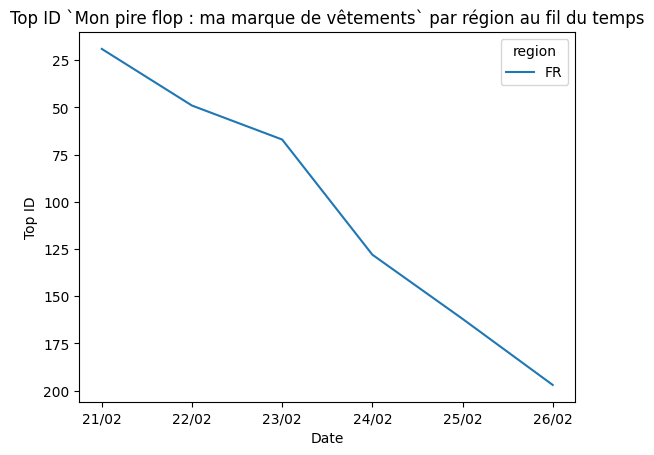

In [71]:
def top_evolution_plot(dt, id):
    data = dt[dt['id'] == id]
    data['fetchedDate'] = pd.to_datetime(data['fetchedDate'])
    data['fetchedDate'] = data['fetchedDate'].dt.strftime('%d/%m')
    
    sns.lineplot(data=data[['fetchedDate', 'topID', 'region']], x='fetchedDate', y='topID', hue='region')
    plt.xlabel('Date')
    plt.ylabel('Top ID')
    plt.title(f"Top ID `{data['title'].values[0]}` par région au fil du temps")
    plt.gca().invert_yaxis()
    plt.show()

top_evolution_plot(df, 'dIlbshbTRlQ')

/tmp/ipykernel_324/639006768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['fetchedDate'] = pd.to_datetime(dt['fetchedDate'])
/tmp/ipykernel_324/639006768.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['fetchedDate'] = dt['fetchedDate'].dt.strftime('%d/%m')
/tmp/ipykernel_324/639006768.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

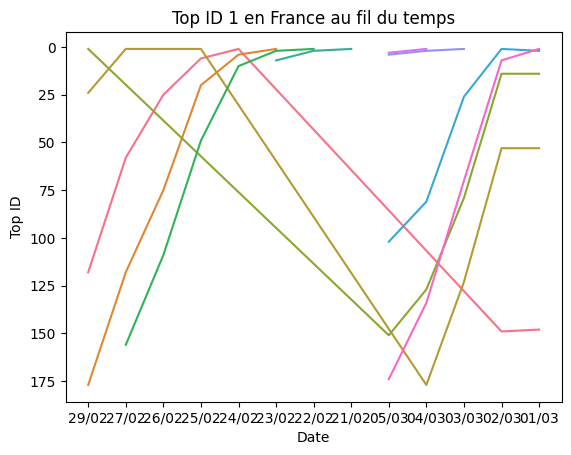

,title,id,publishedAt,duration,ViewCount,likeCount,commentCount,tags,fetchedDate,topID,region,fetchedComments
1517,Paul Mirabel passe après Christopher Nolan pou...,Fce8VXZrngE,2024-02-23 21:42:24+00:00,PT8M6S,1512176,19248.0,549.0,"['49e ceremonie des cesar', 'canalplus', 'cesa...",29/02,118,FR,True
1576,Lebouseuh en roue libre à la télé (il parle av...,Ly-jkqq_y5E,2024-02-22 19:00:15+00:00,PT46M3S,2125993,131837.0,3749.0,"['Vacances des croûtons', 'croûton', 'team cro...",29/02,177,FR,True
1423,TIK TOK M'A FAIT ACHETER ÇA ! #6 (Jamais vu ça...,4j92PHFnp3g,2024-02-25 11:56:47+00:00,PT23M46S,3096268,200158.0,2622.0,"['Joyca', 'video', 'reaction', 'Français', 'ti...",29/02,24,FR,True
1400,VOMIS OU DIS LA VÉRITÉ avec STUDIO DANIELLE (r...,YmUjcJaKTkQ,2024-02-28 18:17:32+00:00,PT32M32S,174031,10658.0,162.0,NaN,29/02,1,FR,False
1355,On s’est fait arnaquer sur la Villa avec les C...,Bh_-IwRflgM,2024-02-21 19:00:04+00:00,PT35M17S,2084543,141826.0,2692.0,"['Vacances des croûtons', 'croûton', 'team cro...",27/02,156,FR,True
1317,Lebouseuh en roue libre à la télé (il parle av...,Ly-jkqq_y5E,2024-02-22 19:00:15+00:00,PT46M3S,2064480,129926.0,3721.0,"['Vacances des croûtons', 'croûton', 'team cro...",27/02,118,FR,True
1257,Paul Mirabel passe après Christopher Nolan pou...,Fce8VXZrngE,2024-02-23 21:42:24+00:00,PT8M6S,1410378,17626.0,503.0,"['49e ceremonie des cesar', 'canalplus', 'cesa...",27/02,58,FR,True
1200,TIK TOK M'A FAIT ACHETER ÇA ! #6 (Jamais vu ça...,4j92PHFnp3g,2024-02-25 11:56:47+00:00,PT23M46S,2562737,179557.0,2401.0,"['Joyca', 'video', 'reaction', 'Français', 'ti...",27/02,1,FR,True
1108,On s’est fait arnaquer sur la Villa avec les C...,Bh_-IwRflgM,2024-02-21 19:00:04+00:00,PT35M17S,2034228,140216.0,2680.0,"['Vacances des croûtons', 'croûton', 'team cro...",26/02,109,FR,True
1024,Paul Mirabel passe après Christopher Nolan pou...,Fce8VXZrngE,2024-02-23 21:42:24+00:00,PT8M6S,1267983,14817.0,452.0,"['49e ceremonie des cesar', 'canalplus', 'cesa...",26/02,25,FR,True


In [101]:
dt = df[df['region'] == 'FR']
top1ID = dt[dt['topID'] == 1]['id'].values
# print(top1ID)
dt = df[df['id'].isin(top1ID)]
dt['fetchedDate'] = pd.to_datetime(dt['fetchedDate'])
dt['fetchedDate'] = dt['fetchedDate'].dt.strftime('%d/%m')
dt.sort_values(by=['fetchedDate'], ascending=False, inplace=True)

sns.lineplot(data=dt[['fetchedDate', 'topID', 'title']], x='fetchedDate', y='topID', hue='title', legend=False)
plt.xlabel('Date')
plt.ylabel('Top ID')
plt.title(f"Top ID 1 en France au fil du temps")
plt.gca().invert_yaxis()
plt.show()
dt